In [3]:
import pairtools
import os
import pairlib.scalings
import pairlib
import bioframe
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn
from NGS import HiCTools as HT
from collections import defaultdict

## Fix path to pbgzip

In [4]:
environment_path = f"/users/michael.mitter/.conda/envs/NGStest/bin/"

# get pre-set PATH environment variable
original_os_path = os.environ.get('PATH')
os_path = original_os_path

# guard PATH against multiple prepending
if environment_path not in original_os_path:
    os_path = environment_path + ':' + original_os_path
%env PATH=$os_path

env: PATH=/users/michael.mitter/.conda/envs/NGStest/bin/:/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/software/2020/software/anaconda3/2019.03/bin;/software/2020/software/anaconda3/2019.03/condabin;/software/2020/software/anaconda3/2019.03/library/bin;/users/michael.mitter/.vscode-server/bin/2aae1f26c72891c399f860409176fe435a154b13/bin:/users/michael.mitter/.conda/envs/gitEnv/bin/:/users/michael.mitter/.vscode-server/bin/2aae1f26c72891c399f860409176fe435a154b13/bin:/software/2020/software/anaconda3/2019.03/condabin:/users/michael.mitter/.conda/envs/gitEnv/bin/:/software/system/utils:/usr/local/bin:/usr/bin:/groups/gerlich/members/MichaelMitter/UCSC_usertools/:/groups/gerlich/members/MichaelMitter/PythonPackages/OnTAD/:/usr/local/sbi

# Define plotting parameters

In [5]:
matplotlib.rcParams.update({"pdf.fonttype": 42})

# Define functions

In [6]:
def recDict():
    return defaultdict(recDict)

# Set WD

In [7]:
os.chdir("/groups/gerlich/experiments/Experiments_004800/004869/")

# Define samples
WT and prometaphase are processed together to be able to downsample the pairs for both conditions

In [8]:
pairDir = ("/groups/gerlich/experiments/Experiments_004700/004755/"
           "Sequencing_data/exp4661/pairs/")

# Load samples

In [9]:
pairs = {interType: HT.loadPairs(os.path.join(pairDir, f"G2.{interType}.pairs.gz"))
                  for interType in ["cis", "trans"]}

# Get chromosome features

In [10]:
hg19_chromsizes = bioframe.fetch_chromsizes('hg19')
arms = HT.getArmsHg19()

# Calculate scaling plots for entire genome

In [11]:
scs = {rType: pairlib.scalings.compute_scaling(
    pairs[rType],
    arms,
    hg19_chromsizes
) for rType in ["cis", "trans"]}

# Calculate scaling plots for highly paired and highly unpaired domains

## Load in domains

In [12]:
regionHigh = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004812/Results/LOLA_PairingDomains/TopTADsTransAmount.bed", sep="\t", header=None)
regionHigh.columns = ["chrom", "start", "end"]
regionLow = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004812/Results/LOLA_PairingDomains/BottomTADsTransAmount.bed", sep="\t", header=None)
regionLow.columns = ["chrom", "start", "end"]

## Calculate scaling plots

In [13]:
scsHigh = {rType: pairlib.scalings.compute_scaling(
    pairs[rType],
    regionHigh,
    hg19_chromsizes
) for rType in ["cis", "trans"]}

In [14]:
scsLow = {rType: pairlib.scalings.compute_scaling(
    pairs[rType],
    regionLow,
    hg19_chromsizes
) for rType in ["cis", "trans"]}

## Filter for assigned reads

In [15]:
filteredHigh = {}
filteredHigh["trans"] = (scsHigh["trans"][0].replace(-1, np.nan).dropna(), scsHigh["trans"][1])
filteredHigh["cis"] = (scsHigh["cis"][0].replace(-1, np.nan).dropna(), scsHigh["cis"][1])

In [16]:
filteredLow = {}
filteredLow["trans"] = (scsLow["trans"][0].replace(-1, np.nan).dropna(), scsLow["trans"][1])
filteredLow["cis"] = (scsLow["cis"][0].replace(-1, np.nan).dropna(), scsLow["cis"][1])

## Construct final dictionary for plotting

In [17]:
scsFinal = recDict()
scsFinal["all"] = scs
scsFinal["highPairing"] = filteredHigh
scsFinal["lowPairing"] = filteredLow

# Plot results

## Construct dictionary for normalization

In [18]:
normDict = {}
for sample in ["all", "highPairing", "lowPairing"]:
    cis = scsFinal[sample]["cis"][0]
    trans = scsFinal[sample]["trans"][0]
    cisAgg = (cis
                .groupby(['min_dist', 'max_dist'])
                .agg({'n_pairs': 'sum', 'n_bp2': 'sum'})
                .reset_index())
    transAgg = (trans
                .groupby(['min_dist', 'max_dist'])
                .agg({'n_pairs': 'sum', 'n_bp2': 'sum'})
                .reset_index())
    cisX = np.sqrt(cisAgg.min_dist * cisAgg.max_dist)
    transX = np.sqrt(transAgg.min_dist * transAgg.max_dist)
    cisValid = cisX < 1000
    transValid = transX < 1000
    cisY = cisAgg.n_pairs/ cisAgg.n_bp2
    transY = transAgg.n_pairs/ transAgg.n_bp2
    cisValidSum = np.sum(cisY[cisValid])
    transValidSum = np.sum(transY[transValid])
    validSum = cisValidSum + transValidSum
    normDict[sample] = validSum

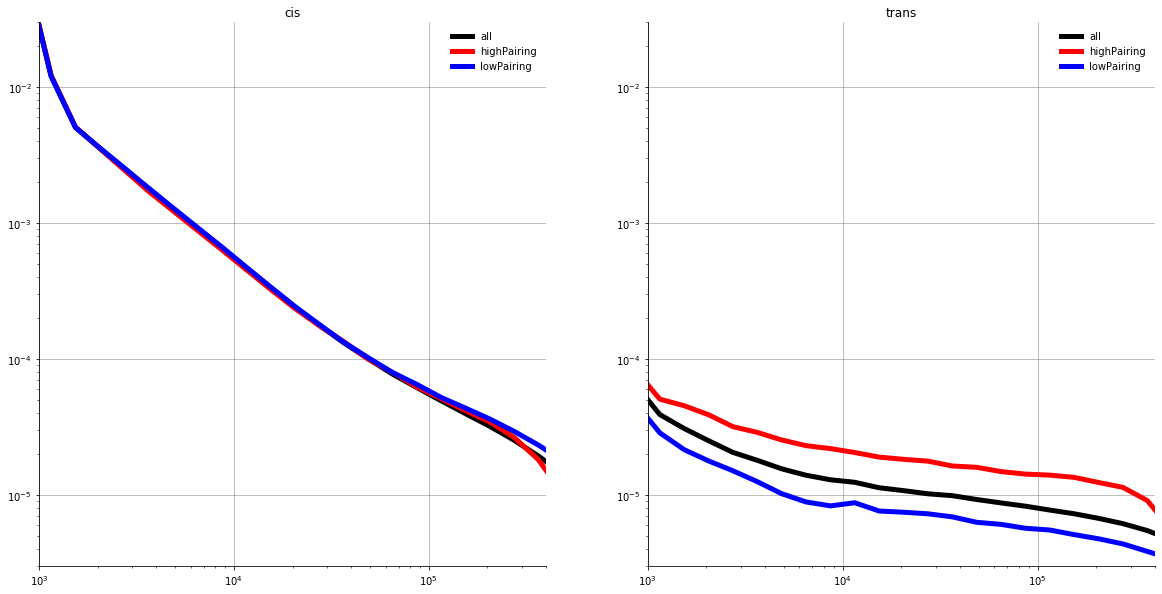

In [28]:
import warnings
warnings.simplefilter("ignore", RuntimeWarning)


colorMap = {"all": "black",
            "highPairing": "red",
            "lowPairing": "blue"}

f, ax = plt.subplots(1, 2)
for index, rType in enumerate(["cis", "trans"]):
    for sample in ["all", "highPairing", "lowPairing"]:
        sc = scsFinal[sample][rType]
        sc_agg = (sc[0]
                  .groupby(['min_dist', 'max_dist'])
                  .agg({'n_pairs': 'sum', 'n_bp2': 'sum'})
                  .reset_index())
        ax[index].loglog(
            np.sqrt(sc_agg.min_dist * sc_agg.max_dist),
            (sc_agg.n_pairs / sc_agg.n_bp2)/normDict[sample],
            label=f'{sample}', lw=5, color=colorMap[sample]
        )
        ax[index].set_title(f"{rType}")
for i in range(0, 2):
    ax[i].grid(lw=0.5, color='gray')
    ax[i].set_xlim(10**3, 4*10**5)
    ax[i].set_ylim(3*10**-6, 3*10**-2)
    ax[i].legend(frameon=False)
f.set_size_inches(20, 10)
sbn.despine()
plt.show()

In [29]:
resultsDir = "/groups/gerlich/experiments/Experiments_004800/004812/Results"
f.savefig(os.path.join(resultsDir, "ScalingPlots_domstart_indRtypePlots.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsDir, "ScalingPlots_domstart_indRtypePlots.pdf"), bbox_inches="tight")